In [1]:
#DATA IMPORT
import pandas as pd
import numpy as np
names=[]
listicle=list(range(1,101))
for i in listicle:
    j="Joke"+str(i)
    names.append(j)
index1=pd.DataFrame(list(range(0,24983)), columns=["Users"])
index2=pd.DataFrame(list(range(24983,48483)), columns=["Users"])
jokes1=pd.read_excel("jester-data-1.xls", header=None, names=names)
jokes2=pd.read_excel("jester-data-2.xls", header=None, names=names)
jokes=pd.concat((jokes1,jokes2))

In [2]:
#DATA INSPECTION
jokes.head(5)
jokes.describe()
jokes.shape
num_user=jokes.shape[0]
num_jokes=jokes.shape[1]

In [3]:
#DATA PREPROCESSING
jokes.replace(99, 0, inplace=True) #NA value is 99 in this dataset
#Standardization is not necessary, features on same scale
sample_jokes=jokes.sample(100)

In [4]:

print(jokes1.shape)
print(jokes2.shape)
num_user

(24983, 100)
(23500, 100)


48483

In [5]:
#SVD
from scipy.linalg import svd
def reconstruct(original_df, k):
    U, sigma, VT = svd(original_df)
    sigma_reduced = np.zeros((k, k))
    np.fill_diagonal(sigma_reduced, sigma[:k])
    U_reduced = U[:, :k]
    VT_reduced = VT[:k, :]
# Reconstruct the Matrix with reduced singular values
    jokes_rec = np.dot(U_reduced, np.dot(sigma_reduced, VT_reduced))
    df_jokes_rec = pd.DataFrame(jokes_rec, columns=names)
    return df_jokes_rec


In [6]:
# Generate Recommendations using SVD
def recommend_items_svd(user_id, original_df,k, num_recommendations=5):
    reconstructed_df=reconstruct(original_df, k)
# Identify items not rated by the user
    unrated_items = original_df.columns[original_df.iloc[user_id] == 0]
# Predict ratings for unrated items
    predicted_ratings = reconstructed_df.loc[user_id, unrated_items]
# Recommend items with highest predicted ratings
    recommended_items = predicted_ratings.nlargest(num_recommendations).index.tolist()
    return recommended_items

In [7]:
recommendations_svd = recommend_items_svd(0, sample_jokes, 10)
print(recommendations_svd)

['Joke71', 'Joke86', 'Joke75', 'Joke76', 'Joke90']


In [8]:
def compare(original_df, k, way='eucl'):
    #This primitive functions gives mean squared error on positions that we have ratings
    reconstructed_df=reconstruct(original_df,k)
    x=original_df.shape
    mean_squared_sum=0
    count_ratings=0
    if way=='eucl':
        for i in range(x[0]):
            for j in range(x[1]):
                if original_df.iat[i,j]!=0:
                    mean_squared_sum+=(original_df.iat[i,j]-reconstructed_df.iat[i,j])*(original_df.iat[i,j]-reconstructed_df.iat[i,j])
                    count_ratings+=1
    if way=='manh':
        for i in range(x[0]):
            for j in range(x[1]):
                if original_df.iat[i,j]!=0:
                    mean_squared_sum+=abs(original_df.iat[i,j]-reconstructed_df.iat[i,j])
                    count_ratings+=1
    return round(mean_squared_sum/count_ratings,2)

In [9]:
def find_k(n, users_sampled, repetitions, way='eucl'):
    listicle=[]
    for i in range(repetitions):
        k=n
        sample_jokes=jokes.sample(users_sampled)
        df_jokes_rec = reconstruct(sample_jokes,k)
        listicle.append(compare(sample_jokes, k, way))
    evaluation=np.mean(listicle)
    return(np.sqrt(evaluation))

In [10]:
find_k(10, 100, 30, 'manh')

1.5878706916286771

In [11]:
values_MSE=[]
for i in range(12):
    values_MSE.append(find_k(i+1,100,30))

K-nearest Neighbour Implementation

In [12]:
names=[]
listicle=list(range(1,101))
for i in listicle:
    j="Joke"+str(i)
    names.append(j)
jokes1=pd.read_excel("jester-data-1.xls", header=None, names=names)
jokes2=pd.read_excel("jester-data-2.xls", header=None, names=names)
jokes=pd.concat((jokes1,jokes2))

In [13]:
jokes_nan=jokes.replace(99,np.nan, inplace=False) #NA value is 99 in this dataset

In [14]:

def nearest_neighbour(frame, distance="eucl"):
    no_users=frame.shape[0]
    distance_array=np.zeros((no_users,no_users))
    if distance=="manh":
        for i in range(frame.shape[0]):
            for j in range(frame.shape[0]):
                diff=frame.iloc[i]-frame.iloc[j]
                dist=np.nansum(abs(diff))
                count=np.sum(~np.isnan(diff))
                if count==0:
                    distance_array[i,j]=20
                else:
                    distance_array[i,j]=dist/(count)
    if distance=="eucl":
        for i in range(frame.shape[0]):
            for j in range(frame.shape[0]):
                diff=frame.iloc[i,:]-frame.iloc[j,:]
                dist=np.nansum((diff)**2)
                count=np.sum(~np.isnan(diff))
                if count==0:
                    distance_array[i,j]=20
                else:
                    distance_array[i,j]=dist/(count)
    index_nearest_all={}
    k=0
    for j in distance_array:
        minim=400
        index=-1
        for i in range(len(j)):
            if j[i]<minim and j[i]!=0:
                minim=j[i]
                index=i
        index_nearest_all[k]=index
        k=k+1
                
    return index_nearest_all
            
    

In [15]:
def return_suggestion(dataframe,ind):
    dictionary=nearest_neighbour(dataframe)
    nearest=dictionary[ind]
    set_user_allowable=set()
    TF_dataframe=dataframe.isna()
    for i in range(dataframe.shape[1]):
        if (TF_dataframe.iat[ind,i]):
            set_user_allowable.add(i)
        set_user_allowable.add(i)
    candidate_joke_index=-1
    n=0
    d=dataframe.iloc[nearest]
    d=d.tolist()
    while candidate_joke_index==-1 and n<101:
        maxim=0
        index=-1
        for i in range(len(d)):
            if d[i]>maxim:
                maxim=d[i]
                index=i
        potential_index=index
        if potential_index in set_user_allowable:
            candidate_joke_index =potential_index
        else:    
            d[potential_index]=0
            n=n+1
    if candidate_joke_index==-1:
        return f"No available jokes from nearest neighbour"
    else:
        return f"Joke{str(candidate_joke_index)}"
    

In [16]:
sample_jokes_nan=jokes_nan.sample(200)
return_suggestion(sample_jokes_nan,23)

'Joke65'

In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import Input, Embedding, Flatten, Dot, Dense
from keras.models import Model
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import load_model

In [18]:
sample_jokes_99=jokes.sample(1000)
x=sample_jokes_99.shape
data_list=[]
for i in range(x[0]):
    for j in range(x[1]):
        if sample_jokes_99.iat[i,j]!=99:
            listicle=[i,j,sample_jokes_99.iat[i,j]]
            data_list.append(listicle)
data_list=pd.DataFrame(data_list, columns=["user_id", "joke_id", "rating"])

n_users = len(data_list.user_id.unique())
n_jokes = len(data_list.joke_id.unique())

In [19]:
joke_input = Input(shape=[1], name="Joke-Input")
joke_embedding = Embedding(n_jokes+1, 5, name="Joke-Embedding")(joke_input)
joke_vec = Flatten(name="Flatten-Books")(joke_embedding)

user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

prod = Dot(name="Dot-Product", axes=1)([joke_vec, user_vec])
model = Model([user_input, joke_input], prod)
model.compile('adam', 'mean_squared_error')

In [20]:
data_list.head(5)

,user_id,joke_id,rating
0,0,0,-3.69
1,0,1,-9.32
2,0,2,-3.50
3,0,3,-9.61
4,0,4,-0.68


In [21]:
train, test = train_test_split(data_list, test_size=0.2, random_state=42)
history = model.fit([train["user_id"], train["joke_id"]], train["rating"], epochs=20, verbose=1)
model.save('regression_model.h5')

Epoch 1/20

1815/1815 [==============================] - 2s 774us/step - loss: 28.0462
Epoch 2/20
1815/1815 [==============================] - 1s 762us/step - loss: 23.9429
Epoch 3/20
1815/1815 [==============================] - 1s 763us/step - loss: 20.8032
Epoch 4/20
1815/1815 [==============================] - 1s 774us/step - loss: 19.8159
Epoch 5/20
1815/1815 [==============================] - 1s 771us/step - loss: 19.3762
Epoch 6/20
1815/1815 [==============================] - 1s 774us/step - loss: 18.9697
Epoch 7/20
1815/1815 [==============================] - 1s 779us/step - loss: 18.5266
Epoch 8/20
1815/1815 [==============================] - 1s 808us/step - loss: 18.0882
Epoch 9/20
1815/1815 [==============================] - 1s 789us/step - loss: 17.7055
Epoch 10/20
1815/1815 [==============================] - 1s 782us/step - loss: 17.4145
Epoch 11/20
1815/1815 [==============================] - 1s 776us/step - loss: 17.2057
Epoch 12/20
1815/1815 [============================

C:\Users\Preyps\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
test_predict = model.predict([test.user_id,test.joke_id])
test['predicted_rating'] = test_predict
MSE=sum((test['rating']-test['predicted_rating'])**2)/len(test['rating'])
print(MSE)

454/454 [==============================] - 0s 650us/step
17.827714203548318


Text(0.5, 1.0, 'Training Error vs. Epochs in Keras Embedding')

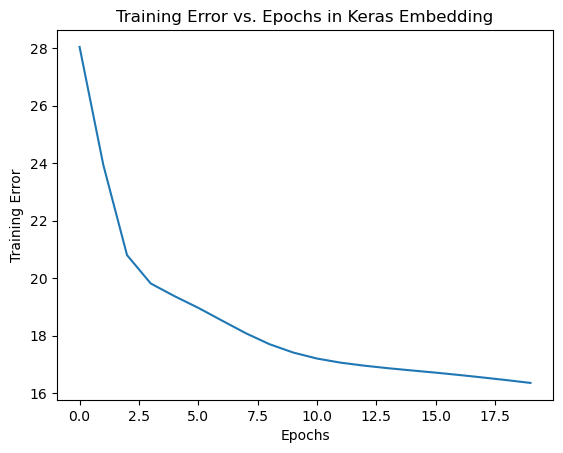

In [23]:
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")
plt.title("Training Error vs. Epochs in Keras Embedding")

Text(0.5, 1.0, 'MSE vs number of latent factors in collaborative filtering')

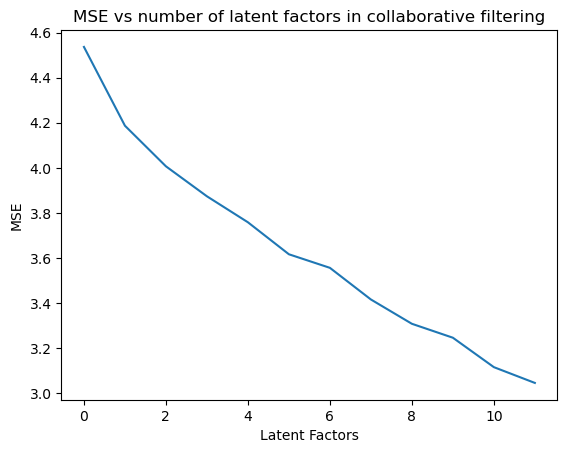

In [24]:
for i in range(len(values_MSE)):
    values_MSE[i]=values_MSE[i]
plt.plot(values_MSE)
plt.xlabel("Latent Factors")
plt.ylabel("MSE")
plt.title("MSE vs number of latent factors in collaborative filtering")